# How Reddit Sentiment Affects Cryptocurrency Price

This notebook analyses the extent social media sentiment has on the price of Bitcoin. By utilizing the data we mined in the previous notebook, we can now evaluate the sentiment of the CryptoCurrency subreddit at a given day. 

In [176]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import pickle
import numpy as np
import pandas_datareader as web
import datetime as dt
import pandas as pd
import re

import matplotlib.pyplot as plt

In [ ]:
# Import reddit post data from previous notebook
with open('data/submission_data.pickle', 'rb') as f:
    daily_threads = pickle.load(f)

Sentiment Analysis is a NLP technique used to evaluate the polarity of a given text to view if it is seen as 'positive' or 'negative'. For example, words such as 'good' and 'happy' are regarded as positive words and if present in a sentence; it will increase the polarity of said sentence. On the contrary, negative words such as 'terrible' and 'sad' would reduce the polarity of the sentence. For our needs, we will take the titles of Reddit posts (e.g. "Bitcoin falls 7%") and calculate its sentiment (negative).



In [211]:
# Example
text = "I hate Mondays."
sia = SIA()
sentiment = sia.polarity_scores(text)
print(sentiment)


{'neg': 0.787, 'neu': 0.213, 'pos': 0.0, 'compound': -0.5719}


In this example we can see that "I hate Mondays" has a .79 negative score, which indicates that it is a negative sentence. A more clearer way - and the one we will be using - to see that if a sentence is negative or positive is to use its compound, as seen above. That is, the positive, neutral and negative scores are combined and normalized between -1 and 1. Where a score of -1 would indicate the text is extremely negative, and vice versa.

## Updating Sentiment Analysis for Reddit
The sentiment analysis module we will be using (Vader) already has a dictionary of positive and negative words, and thus can be used out-of-the-box. However, the lexicon used on the CryptoCurrency subreddit is different from what is used in a more general setting. Synonymous words that have one meaning could mean something else in a different context. For example, 'bulls' and 'bears' are neutral words and have neutral sentiment in a general setting. However, in finance, 'bulls' refers to a 'bull market' and has a positive connotation, while 'bears' refers to a 'bear market' and has a negative connotation. For our sentiment analysis to be as accurate as possible, we need to incorporate the language used on CryptoCurrency into our sentiment dictionary. 

In [212]:
# Dictionary of words typically used on finance subreddits and its general sentiment
new_words = {
    'lambo': 4.0,
    'rekt': -4.0,
    'citron': -4.0,
    'hidenburg': -4.0,
    'moon': 4.0,
    'Elon': 2.0,
    'hodl': 2.0,
    'highs': 2.0,
    'mooning': 4.0,
    'long': 2.0,
    'short': -2.0,
    'call': 4.0,
    'calls': 4.0,
    'put': -4.0,
    'puts': -4.0,
    'break': 2.0,
    'tendie': 2.0,
    'tendies': 2.0,
    'town': 2.0,
    'overvalued': -3.0,
    'undervalued': 3.0,
    'buy': 4.0,
    'sell': -4.0,
    'gone': -1.0,
    'gtfo': -1.7,
    'fomo': 2.0,
    'paper': -1.7,
    'bullish': 3.7,
    'bearish': -3.7,
    'bagholder': -1.7,
    'stonk': 1.9,
    'green': 1.9,
    'money': 1.2,
    'print': 2.2,
    'rocket': 2.2,
    'bull': 2.9,
    'bear': -2.9,
    'pumping': 1.0,
    'sus': -3.0,
    'offering': -2.3,
    'rip': -4.0,
    'downgrade': -3.0,
    'upgrade': 3.0,
    'maintain': 1.0,
    'pump': 1.9,
    'hot': 2,
    'drop': -2.5,
    'rebound': 1.5,
    'crack': 2.5, }

sia.lexicon.update(new_words)

In [213]:
# Calculate sentiment of CryptoCurrency by day
day_sentiment = np.zeros(len(daily_threads))
for i in range(len(daily_threads)):

    if daily_threads[i] is None:
        day_sentiment[i] = np.nan 
        continue

    posts = daily_threads[i]

    for _,post in posts.iterrows():
        day_sentiment[i] += sia.polarity_scores(post["title"])["compound"]
        


## Importing Bitcoin Data

In [217]:
# Get prices from 2021
start = dt.datetime(2021,1,2)
end = dt.datetime(2021,12,31)


btc = web.DataReader('BTC-USD', 'yahoo', start, end)
btc.drop(columns = ['High', 'Low', 'Open', 'Close', 'Volume'], inplace = True)
btc.rename(columns={'Adj Close': 'BTC Price'}, inplace = True)
btc.head()

,BTC Price
Date,
2021-01-01,29374.152344
2021-01-02,32127.267578
2021-01-03,32782.023438
2021-01-04,31971.914062
2021-01-05,33992.429688


In [218]:

# Append reddit daily sentiment to BTC dataframe
btc["sentiment"] = day_sentiment
btc["sentiment"].fillna(method="bfill",inplace=True)
btc.head()

,BTC Price,sentiment
Date,,
2021-01-01,29374.152344,34.0896
2021-01-02,32127.267578,54.8643
2021-01-03,32782.023438,98.7166
2021-01-04,31971.914062,91.5431
2021-01-05,33992.429688,75.7527


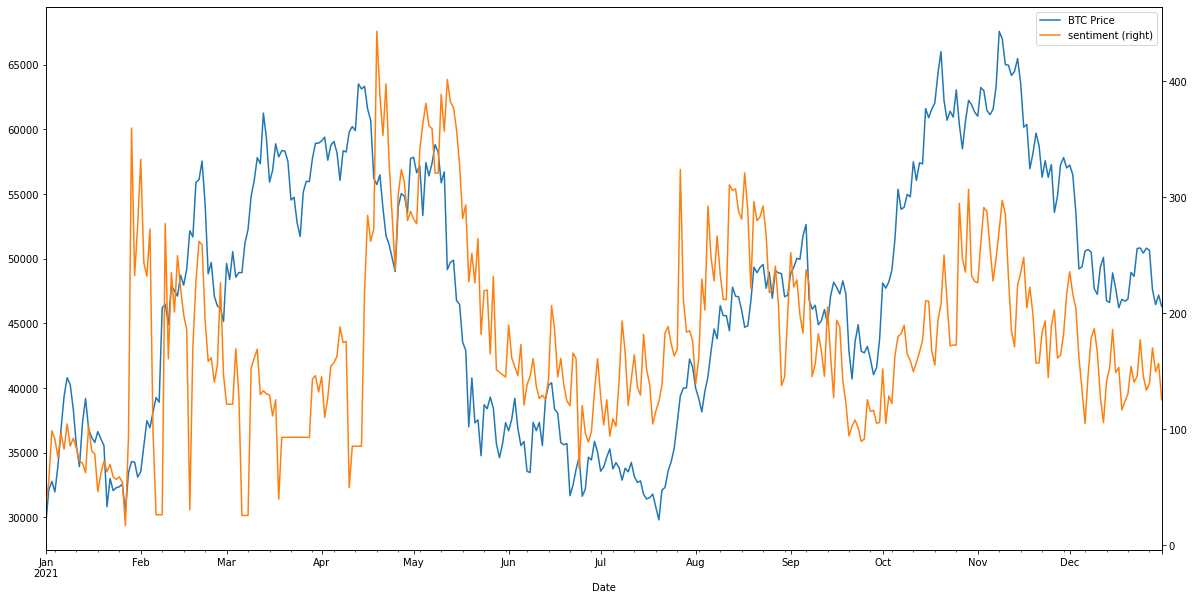

In [219]:
btc[['BTC Price',"sentiment"]].plot(secondary_y = "sentiment",figsize=(20, 10));

Although we can see semblance of a pattern, there is still a lot of noise present in the sentiment data. We will use the Fourier Transform to denoise the data. Here, we transform the sentiment data into the frequency domain. Then, we find a threshold to remove the high and low frequencies that are causing the noise. Finally, we revert back to the time domain.

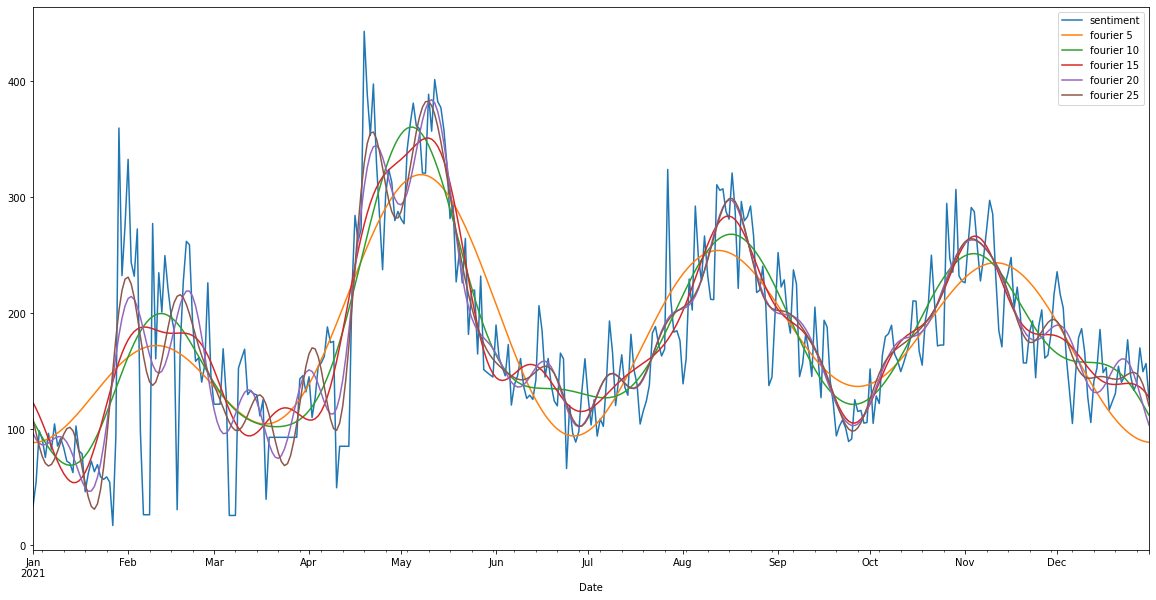

In [220]:
price_fourier = np.fft.fft(np.asarray(btc["sentiment"].tolist()))
fourier_df = pd.DataFrame({'fourier':price_fourier}) # add to a dataframe
fourier_list = np.asarray(fourier_df['fourier'].tolist())  # extract fourier score as array


for num_ in range(5,30,5): # iterate through different thresholds
    fourier_list_m10= np.copy(fourier_list); fourier_list_m10[num_:-num_]=0 
    # transform back into time spectrum append each fourier to dataframe with name of fourier
    btc['fourier '+str(num_)]=np.fft.ifft(fourier_list_m10)
    
    # Sentiment is currently represented as a complex number, we need to get the real part for plotting.
    btc['fourier ' + str(num_)]=btc['fourier ' + str(num_)].apply(lambda x: np.real(x))
    
btc[["sentiment","fourier 5","fourier 10","fourier 15","fourier 20","fourier 25",]].plot(figsize=(20, 10));

From a visual inspection; fourier 25 seems to best represent the sentiment

In [221]:
# Copy smoothed sentiment to sentiment column
btc["sentiment"] = btc["fourier 25"]
btc.drop(columns = ["fourier 5","fourier 10","fourier 15","fourier 20","fourier 25"], inplace= True)
btc.head()

,BTC Price,sentiment
Date,,
2021-01-01,29374.152344,108.436530
2021-01-02,32127.267578,96.519631
2021-01-03,32782.023438,85.516790
2021-01-04,31971.914062,76.587990
2021-01-05,33992.429688,70.683456


Text(10, 35, 'Federal Reserve has no intention to ban Bitcoin')

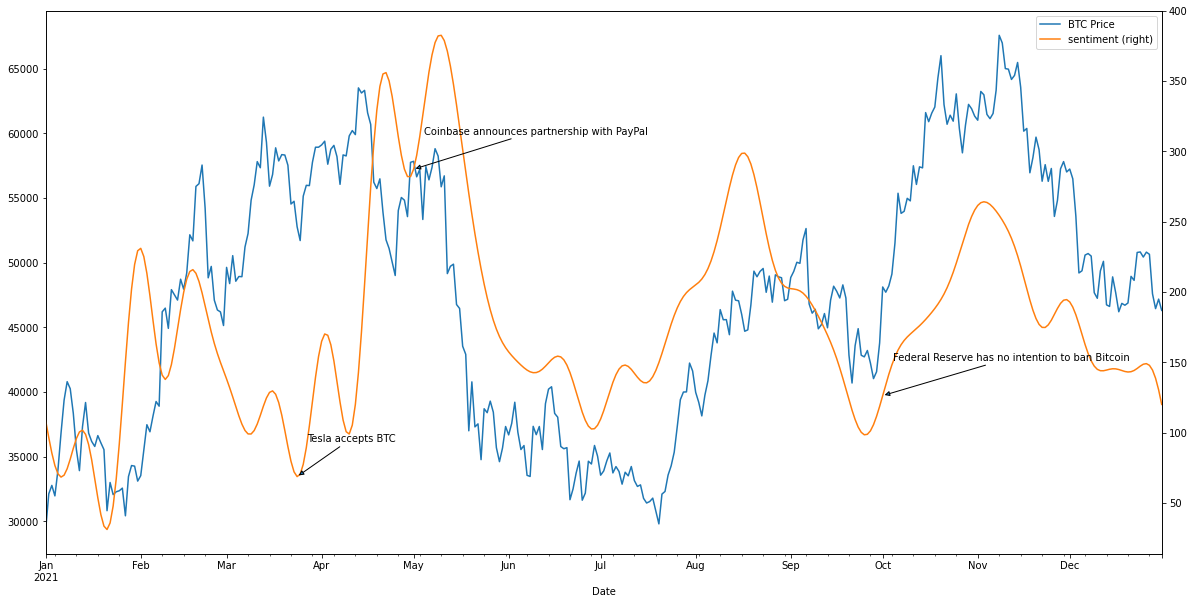

In [222]:
# btc[['BTC Price',  'fourier 25']].plot(secondary_y="fourier 25",figsize=(20, 10));
btc[['BTC Price',"sentiment"]].plot(secondary_y="sentiment",figsize=(20, 10));

plt.annotate("Tesla accepts BTC",("2021-03-24",btc.loc["2021-03-24", : ]["sentiment"]),xytext=(10, 35),textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
plt.annotate("Coinbase announces partnership with PayPal",("2021-05-01",btc.loc["2021-05-01", : ]["sentiment"]),xytext=(10, 35),textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
plt.annotate("Federal Reserve has no intention to ban Bitcoin",("2021-10-01",btc.loc["2021-10-01", : ]["sentiment"]),xytext=(10, 35),textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))



We can see at the end of a downtrend, the sentiment of Bitcoin reverses positively before it is reflected in its price. Perhaps we can use social media sentiment to predict a reversal from a downtrend.

## How Reddit Sentiment affects Individual Cryptocurrencies (ETH)

Now that we have seen how the general sentiment of /r/CryptoCurrencies affects the price of Bitcoin, we will now transition to see how the sentiment towards a specific cryptocurrency-in this case Ethereum-affects its price.

In [223]:
# Get all reddit posts that mention Ethereum
eth_posts = []
for day in daily_threads:
    if day is None: # Skip if eth isnt mentioned at a given day
        continue
        
    day.drop_duplicates(subset ="title", keep = False, inplace = True)
    for i,post in day.iterrows():
        title =  re.sub('[^a-zA-Z0-9 \n\.]', '', post.title).lower().split(" ") # remove special characters, and split words into list
        if "eth" in title or "ethereum" in title or "vitalik" in title or "buterin" in title:
            post_date = dt.datetime.fromtimestamp(post.date).replace(hour=0, minute=0, second = 0)
            eth_posts.append([post.title,post_date]) # Save the post title, and the date it was posted
            
df_eth_posts = pd.DataFrame(eth_posts)

print("Number of posts about Ethereum:",len(df_eth_posts))
print(df_eth_posts.head())


Number of posts about Ethereum: 24859
                                                             0          1
0  Fuel Labs: "To wrap up the year, Fuel v1 is now official... 2021-01-01
1                         When you go balls deep into Eth 2.0. 2021-01-01
2  How likely is it that any other coin will reach similar ... 2021-01-01
3             I straight up transfered Moons to my ETH account 2021-01-01
4            Bitcoin vs Ethereum explanation in one picture :) 2021-01-01


In [224]:
# Create a list of dataframes, where each dataframe represents all eth related posts at a given day
start_date = dt.datetime(2021,1,1)
end_date =  dt.datetime(2022,1,30)
current_date = start_date
date_list = [start_date + dt.timedelta(days=x) for x in range(365)]
eth_daily_posts = []

for date in date_list:
    daily_eth_posts = df_cardano.loc[df_cardano[1] == date]
    
    if len(daily_eth_posts) == 0:
        eth_daily_posts.append(None)
    else:
        eth_daily_posts.append(daily_eth_posts)
        

In [225]:
# Get daily sentiment 
eth_sentiment = np.zeros(len(eth_daily_posts))
for i in range(len(eth_sentiment)):
    day = eth_daily_posts[i]
    
    if day is None:
        eth_daily_posts[i] = np.nan #If no data for this day, append nan
        continue
    
    for _,post in day.iterrows():
        eth_sentiment[i] += sia.polarity_scores(post[0])["compound"]

In [226]:
# Get Ethereum time series data
eth = web.DataReader('ETH-USD', 'yahoo', start, end)
eth.drop(columns = ['High', 'Low', 'Open', 'Close', 'Volume'], inplace = True)
eth.rename(columns={'Adj Close': 'ETH Price'}, inplace = True)
eth["Eth Sentiment"] = eth_sentiment
eth["Eth Sentiment"].fillna(method="bfill",inplace=True)



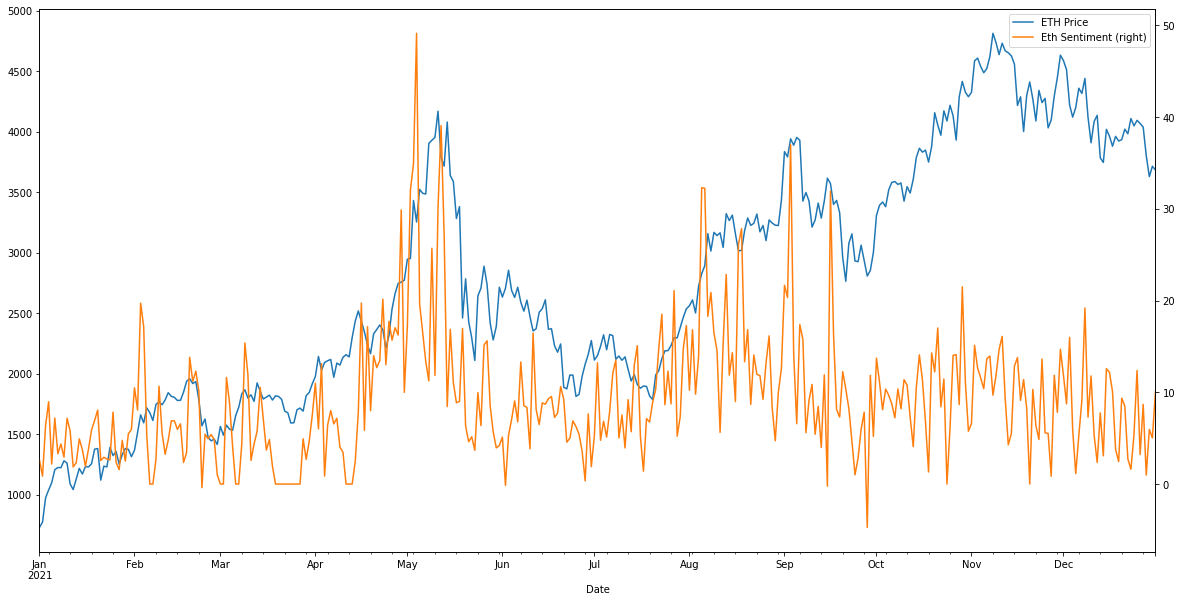

In [227]:
eth[['ETH Price',"Eth Sentiment"]].plot(secondary_y = "Eth Sentiment",figsize=(20, 10));

Once again, there is a lot of noise in the sentiment data. As the same as before, we will use the Fourier Transform to denoise the data.

In [228]:
price_fourier = np.fft.fft(np.asarray(eth["Eth Sentiment"].tolist()))
fourier_df = pd.DataFrame({'fourier':price_fourier}) # add to a dataframe
fourier_list = np.asarray(fourier_df['fourier'].tolist())  # extract fourier score as array
for num_ in range(5,30,5): # iterate through different thresholds
    fourier_list_m10= np.copy(fourier_list); fourier_list_m10[num_:-num_]=0 
    # transform back into time spectrum append each fourier to dataframe with name of fourier
    eth['fourier '+str(num_)]=np.fft.ifft(fourier_list_m10)
    
    # Sentiment is currently represented as a complex number, we need to get the real part for plotting.
    eth['fourier ' + str(num_)]=eth['fourier ' + str(num_)].apply(lambda x: np.real(x))

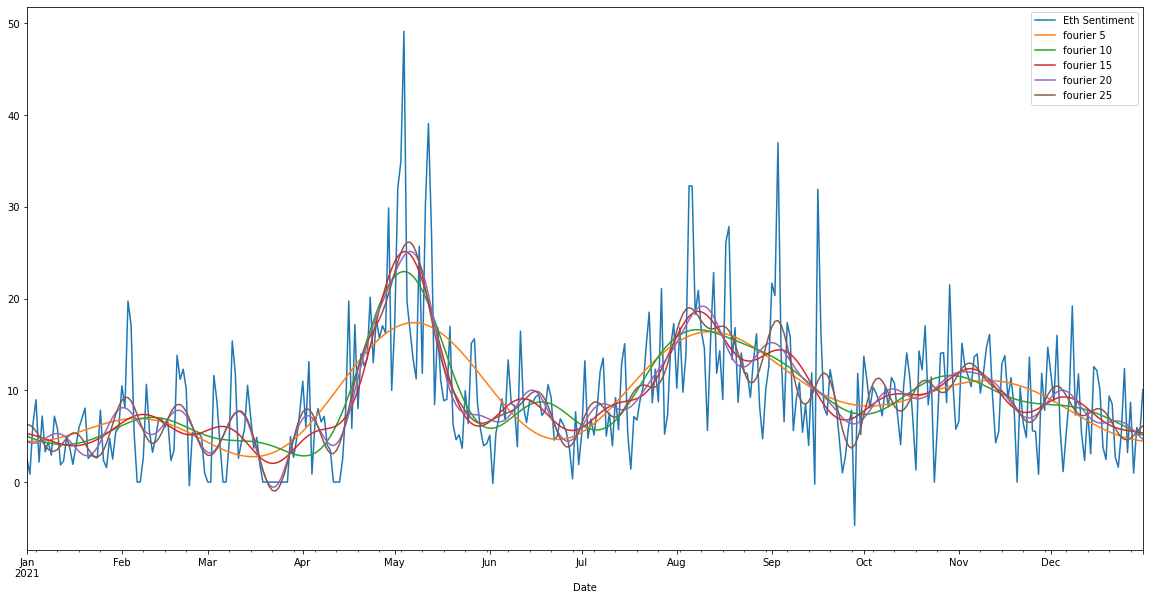

In [229]:
eth[["Eth Sentiment","fourier 5","fourier 10","fourier 15","fourier 20","fourier 25"]].plot(figsize=(20, 10));

We will use the fourier 20 threshold as it seems to show the best results.

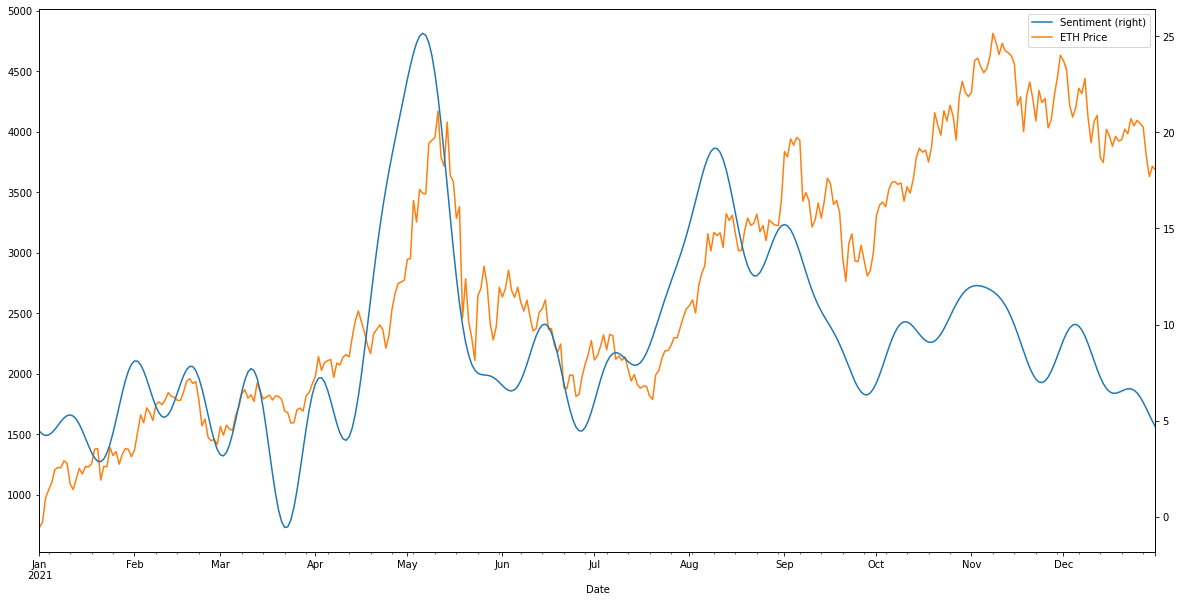

In [230]:
eth.rename(columns={'fourier 20': 'Sentiment'},inplace = True)
eth[["Sentiment","ETH Price"]].plot(secondary_y= "Sentiment",figsize=(20, 10));

Compared to the BTC graph, the sentiment towards Ethereum correlates more to its price. In addition, it is interesting to see that similar to the case with BTC, the sentiment towards Ethereum improves positively prior to a sharp increase in its price.
